# 10 Minutes to kanoa

This notebook provides a comprehensive introduction to **kanoa** - an AI-powered analytics interpreter.

## Features Covered

1. **Multi-Backend Support**: vLLM, Gemini, Claude, and OpenAI
2. **Knowledge Base Integration**: Dynamic creation from online reports
3. **Matplotlib Figure Interpretation**: Direct visualization analysis
4. **DataFrame Analysis**: Tabular data interpretation
5. **Cost Tracking**: Token usage and cost monitoring

---

## Setup

First, let's import the necessary libraries and set up our environment.

In [2]:
import os
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from markitdown import MarkItDown

import kanoa
from kanoa.utils.logging import log_info

# enable kanoa internals logging for debugging
kanoa.options.verbose = True
# kanoa.options.verbose = 2 # max verbosity

# Set plot style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11

# Load API keys from user config
config_dir = Path.home() / ".config" / "kanoa"
if (config_dir / ".env").exists():
    load_dotenv(config_dir / ".env")

log_info("✓ Setup complete!")


<div style="background: rgba(128, 128, 128, 0.04);
            border: 1px solid rgba(128, 128, 128, 0.15);
            border-left: 3px solid rgba(128, 128, 128, 0.25);
            padding: 14px 18px;
            margin: 10px 0;
            border-radius: 6px;
            font-size: 0.9em;
            line-height: 1.5;
            font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;
            box-sizing: border-box;
            max-width: 100%;
            overflow-x: auto;
            word-wrap: break-word;">

<div style="opacity: 0.85;">✓ Setup complete!</div>

</div>


## 1. Create Synthetic Climate Data

We'll create realistic synthetic data that mimics actual climate observations, specifically Global Temperature Anomalies.

In [3]:
# Set seed for reproducibility
np.random.seed(42)

# Create time axis (1960-2025)
years = np.arange(1960, 2026)
n_years = len(years)

# Global Temperature Anomaly (relative to 1951-1980 baseline)
# Starts near 0, accelerates to ~1.2°C by 2025
trend = 0.018 * (years - 1960)  # ~0.18°C/decade base trend
acceleration = 0.0002 * (years - 1960) ** 1.5  # Accelerating component
enso_signal = 0.15 * np.sin(2 * np.pi * (years - 1960) / 3.7)  # ENSO-like
volcanic = np.zeros_like(years, dtype=float)
volcanic[years == 1991] = -0.3  # Pinatubo
volcanic[years == 1982] = -0.2  # El Chichón
noise = np.random.normal(0, 0.08, n_years)

temp_anomaly = trend + acceleration + enso_signal + volcanic + noise

# Create DataFrame
climate_df = pd.DataFrame(
    {
        "Year": years,
        "Temperature_Anomaly_C": temp_anomaly,
    }
)

# 5-year running mean
climate_df["Temp_5yr_Mean"] = (
    climate_df["Temperature_Anomaly_C"].rolling(window=5, center=True).mean()
)

log_info("Synthetic climate DataFrame created:")
log_info(climate_df.tail(5))


<div style="background: rgba(128, 128, 128, 0.04);
            border: 1px solid rgba(128, 128, 128, 0.15);
            border-left: 3px solid rgba(128, 128, 128, 0.25);
            padding: 14px 18px;
            margin: 10px 0;
            border-radius: 6px;
            font-size: 0.9em;
            line-height: 1.5;
            font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;
            box-sizing: border-box;
            max-width: 100%;
            overflow-x: auto;
            word-wrap: break-word;">

<div style="opacity: 0.85;">Synthetic climate DataFrame created:</div>
<div style="margin: 8px 0;"><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Year</th>
      <th>Temperature_Anomaly_C</th>
      <th>Temp_5yr_Mean</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>61</th>
      <td>2021</td>
      <td>1.191153</td>
      <td>1.158409</td>
    </tr>
    <tr>
      <th>62</th>
      <td>2022</td>
      <td>0.975266</td>
      <td>1.214832</td>
    </tr>
    <tr>
      <th>63</th>
      <td>2023</td>
      <td>1.163663</td>
      <td>1.222887</td>
    </tr>
    <tr>
      <th>64</th>
      <td>2024</td>
      <td>1.462827</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>65</th>
      <td>2025</td>
      <td>1.321523</td>
      <td>NaN</td>
    </tr>
  </tbody>
</table>
</div></div>

</div>


## 2. Basic Interpretation (No Knowledge Base)

Let's visualize the data and have kanoa interpret it using its internal knowledge.

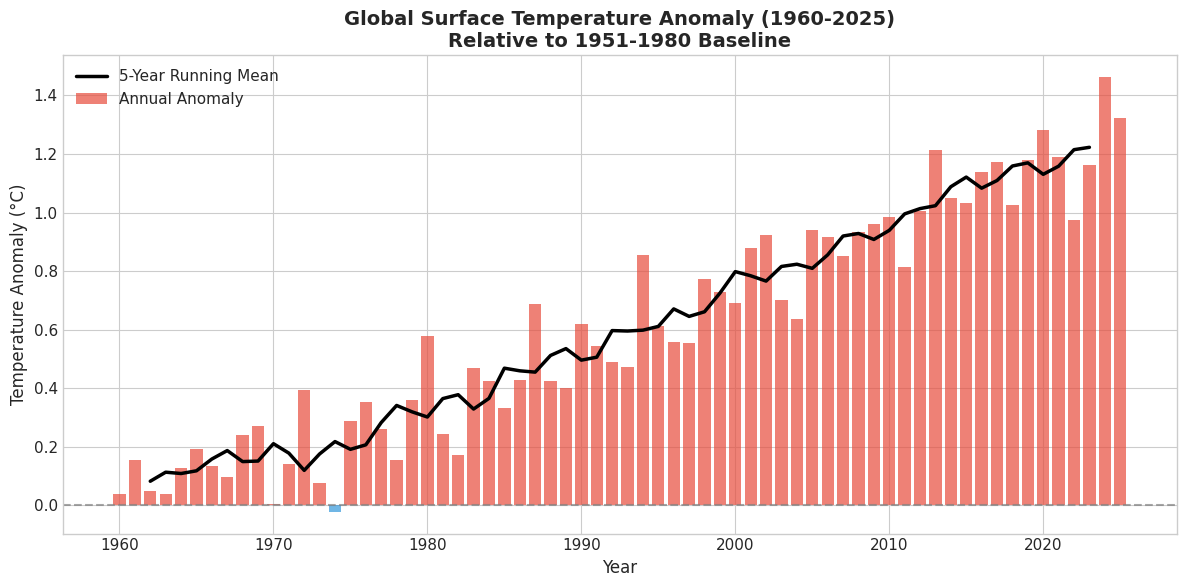


<div style="background: rgba(128, 128, 128, 0.04);
            border: 1px solid rgba(128, 128, 128, 0.15);
            border-left: 3px solid rgba(128, 128, 128, 0.25);
            padding: 14px 18px;
            margin: 10px 0;
            border-radius: 6px;
            font-size: 0.9em;
            line-height: 1.5;
            font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;
            box-sizing: border-box;
            max-width: 100%;
            overflow-x: auto;
            word-wrap: break-word;">

<div style="opacity: 0.85;">Interpreting without Knowledge Base...</div>

</div>



<div style="background: rgba(186, 164, 217, 0.12);
            border: 1px solid rgba(186, 164, 217, 0.35);
            border-left: 3px solid rgba(186, 164, 217, 0.75);
            padding: 14px 18px;
            margin: 10px 0;
            border-radius: 6px;
            font-size: 0.9em;
            line-height: 1.5;
            font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;
            box-sizing: border-box;
            max-width: 100%;
            overflow-x: auto;
            word-wrap: break-word;">

<div style="font-weight: 600; margin-bottom: 10px; font-size: 1.1em; opacity: 0.9;">kanoa</div>
<div style="opacity: 0.85;">Authenticating with Google Cloud (Model: gemini-2.5-flash)...</div>
<div style="opacity: 0.85;">Generating content with gemini-2.5-flash...</div>
<div style="opacity: 0.85;">Usage: 2,419 in / 1,174 out</div>
<div style="opacity: 0.85;">Content too small for caching (~361 tokens < 1024)</div>
<div style="opacity: 0.85;">Generating content with gemini-2.5-flash...</div>
<div style="opacity: 0.85;">Usage: 2,953 in / 1,169 out</div>

</div>



<div style="background: rgba(2, 62, 138, 0.08);
            border: 1px solid rgba(2, 62, 138, 0.3);
            border-left: 4px solid rgba(2, 62, 138, 0.8);
            padding: 16px 20px;
            margin: 10px 0;
            border-radius: 8px;
            backdrop-filter: blur(5px);
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.08);">

<div style="font-weight: 600; margin-bottom: 12px; opacity: 0.9; font-size: 1.1em; font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;">gemini</div>

Here's a technical interpretation of the provided image:

### 1. Summary

The output displays global surface temperature anomalies from 1960 to 2025, relative to a 1951-1980 baseline. It presents both annual temperature anomalies (salmon bars) and a 5-year running mean (solid black line), illustrating the trend in global warming over this period.

### 2. Key Observations

*   **Consistent Warming Trend**: Both the annual anomalies and the 5-year running mean show a clear and pronounced upward trend in global surface temperatures since 1960.
*   **Accelerating Warming**: The rate of warming appears to accelerate, particularly from the 1980s onwards, with the steepest increases observed in the 21st century.
*   **Magnitude of Anomalies**: Early in the period (1960s-1970s), anomalies were generally small, with a few instances slightly below the baseline (e.g., around 1974). By the 2020s, anomalies consistently exceed +1.0 °C, with the latest projected year (2025) reaching approximately +1.45 °C.
*   **Reduced Variability in Running Mean**: The 5-year running mean effectively smooths out inter-annual variability, providing a clearer signal of the underlying long-term warming trend.
*   **Record Highs**: The highest temperature anomalies on record within this timeframe are observed in the most recent years (2020s), with projected increases up to 2025.
*   **Dominance of Positive Anomalies**: After the early 1970s, almost all annual anomalies are positive, indicating a sustained period of temperatures warmer than the 1951-1980 baseline.

### 3. Technical Interpretation

*   **Climate Change Evidence**: The persistent and increasing positive temperature anomalies, especially the accelerating trend indicated by the running mean, provide strong evidence of global climate change. The shift from near-baseline or slightly negative anomalies in the 1960s/70s to consistently high positive anomalies in recent decades quantifies the magnitude of warming.
*   **Baseline Significance**: The 1951-1980 baseline is a standard climatological reference period used by agencies like NASA GISS. Anomalies relative to this period help to visualize deviations from a relatively stable, industrially-influenced climate window prior to the steep acceleration of warming.
*   **Running Mean as a Trend Indicator**: The 5-year running mean serves as a low-pass filter, removing high-frequency noise (year-to-year natural variability) and allowing the underlying multi-year warming signal to be more clearly observed. Its continuous upward slope confirms that recent warm years are not isolated events but part of a sustained trend.
*   **Implications of Magnitude**: Anomalies exceeding +1.0 °C (and approaching +1.5 °C) relative to the chosen baseline are significant and indicate that the planet is already experiencing substantial warming, raising concerns about reaching critical climate thresholds.

### 4. Potential Issues

*   **Future Data (2023-2025) Clarity**: It is unclear if the data for 2023-2025 are observed provisional data (e.g., partial year averages), hindcasts, or future projections from climate models. This distinction is critical as projections carry inherent uncertainties. If observed, 2023 would be the full year, while 2024 and 2025 would necessarily be projections.
*   **Data Source and Uncertainty**: The graph does not provide information about the data source (e.g., NASA GISS, NOAA NCDC, HadCRUT) or the associated measurement and calculation uncertainties for the anomalies.
*   **Baseline Choice Impact**: While 1951-1980 is common, different baselines (e.g., pre-industrial, 1981-2010) would shift the absolute anomaly values, though the trend would remain consistent.
*   **Methodology of Running Mean**: The exact methodology for calculating the 5-year running mean (e.g., centered, trailing average) is not specified, which could slightly affect its representation at the endpoints.

### 5. Recommendations

*   **Clarify Data for Future Years**: Explicitly state whether the data for 2023, 2024, and 2025 are observed, provisional (e.g., YTD), or projections, and include relevant uncertainty bounds for projected data.
*   **Quantify Warming Rates**: Calculate and present the decadal warming rates over different periods (e.g., 1960-1980, 1980-2000, 2000-2025) to numerically demonstrate the acceleration of warming.
*   **Provide Data Source**: Include the source of the temperature anomaly data for transparency and reproducibility.
*   **Contextualize with Policy Targets**: Relate the observed anomalies to international climate targets, such as the 1.5°C or 2.0°C warming limits set by the Paris Agreement, to underscore the policy implications of the current warming trend.
*   **Consider Impact Indicators**: Supplement this temperature anomaly data with related climate indicators (e.g., ocean heat content, ice melt, extreme event frequency) to provide a more holistic view of climate change impacts.

---
<small>**gemini-2.5-flash** · 2,419→1,174 tokens · $0.0000</small>

</div>


In [4]:
# Create temperature anomaly visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot annual data
colors = [
    "#3498db" if t < 0 else "#e74c3c" for t in climate_df["Temperature_Anomaly_C"]
]
ax.bar(
    climate_df["Year"],
    climate_df["Temperature_Anomaly_C"],
    color=colors,
    alpha=0.7,
    width=0.8,
    label="Annual Anomaly",
)

# Plot 5-year running mean
ax.plot(
    climate_df["Year"],
    climate_df["Temp_5yr_Mean"],
    color="black",
    linewidth=2.5,
    label="5-Year Running Mean",
)

# Reference lines
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.7)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Temperature Anomaly (°C)", fontsize=12)
ax.set_title(
    "Global Surface Temperature Anomaly (1960-2025)\n"
    + "Relative to 1951-1980 Baseline",
    fontsize=14,
    fontweight="bold",
)
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

log_info("Interpreting without Knowledge Base...")

# Initialize interpreter
interpreter = kanoa.AnalyticsInterpreter(
    backend="gemini", model="gemini-2.5-flash", track_costs=True
)

result = interpreter.interpret_figure(
    fig=fig,
    context="Global temperature anomaly data",
    focus="Analyze the warming trend",
    display_result=True,
    stream=False,
)

## 3. Knowledge Base Integration

We can dynamically create a knowledge base from recent online reports. Here, we'll download the **NOAA Global Climate Report from August 2025** and use `markitdown` to extract its content. This allows the model to reference specific recent data and findings.

In [5]:
# URL for NOAA Global Climate Report - August 2025
url = "https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202508"

log_info(f"Downloading report from {url}...")

# Download the page content
response = requests.get(url)
response.raise_for_status()

# Save to a temporary HTML file
with tempfile.NamedTemporaryFile(suffix=".html", delete=False) as tmp_html:
    tmp_html.write(response.content)
    tmp_html_path = tmp_html.name

# Use MarkItDown to convert to Markdown
md = MarkItDown()
result = md.convert(tmp_html_path)
markdown_content = result.text_content

# Clean up HTML file
os.remove(tmp_html_path)

# Create a temporary KB directory
kb_temp_dir = tempfile.TemporaryDirectory()
kb_dir = Path(kb_temp_dir.name)
kb_file = kb_dir / "noaa_report_aug_2025.md"

with open(kb_file, "w") as f:
    f.write(markdown_content)

log_info(
    f"✓ Knowledge base created at {kb_file}!\nPreview:\n{markdown_content[:30]}..."
)


<div style="background: rgba(128, 128, 128, 0.04);
            border: 1px solid rgba(128, 128, 128, 0.15);
            border-left: 3px solid rgba(128, 128, 128, 0.25);
            padding: 14px 18px;
            margin: 10px 0;
            border-radius: 6px;
            font-size: 0.9em;
            line-height: 1.5;
            font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;
            box-sizing: border-box;
            max-width: 100%;
            overflow-x: auto;
            word-wrap: break-word;">

<div style="opacity: 0.85;">Downloading report from https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202508...</div>
<div style="opacity: 0.85;">✓ Knowledge base created at /tmp/tmpw4euazn9/noaa_report_aug_2025.md!
Preview:
[Skip to main content](#main-c...</div>

</div>


In [6]:
log_info("Interpreting WITH Knowledge Base...")

# Initialize interpreter WITH knowledge base
interpreter_with_kb = interpreter.with_kb(kb_path=str(kb_dir), kb_type="text")

result_kb = interpreter_with_kb.interpret_figure(
    fig=fig,
    context="Global temperature anomaly data (1960-2025)",
    focus="Compare the data trends with the findings in the NOAA August 2025 report",
    display_result=True,
    stream=False,
)


<div style="background: rgba(128, 128, 128, 0.04);
            border: 1px solid rgba(128, 128, 128, 0.15);
            border-left: 3px solid rgba(128, 128, 128, 0.25);
            padding: 14px 18px;
            margin: 10px 0;
            border-radius: 6px;
            font-size: 0.9em;
            line-height: 1.5;
            font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;
            box-sizing: border-box;
            max-width: 100%;
            overflow-x: auto;
            word-wrap: break-word;">

<div style="opacity: 0.85;">Interpreting WITH Knowledge Base...</div>

</div>



<div style="background: rgba(2, 62, 138, 0.08);
            border: 1px solid rgba(2, 62, 138, 0.3);
            border-left: 4px solid rgba(2, 62, 138, 0.8);
            padding: 16px 20px;
            margin: 10px 0;
            border-radius: 8px;
            backdrop-filter: blur(5px);
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.08);">

<div style="font-weight: 600; margin-bottom: 12px; opacity: 0.9; font-size: 1.1em; font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;">gemini</div>

Here's a technical interpretation of the provided global surface temperature anomaly chart:

### 1. Summary

The chart displays global surface temperature anomalies from 1960 to 2025, relative to a 1951-1980 baseline period. It presents both annual anomalies (salmon-colored bars) and a 5-year running mean (black line) to highlight trends. The data clearly illustrates a significant and accelerating warming trend over this period.

### 2. Key Observations

*   **Overall Warming Trend:** There is a clear and consistent upward trend in global surface temperature anomalies throughout the entire period shown (1960-2025).
*   **Dominant Positive Anomalies:** The vast majority of annual anomalies are positive, indicating temperatures warmer than the 1951-1980 baseline. A few minor negative anomalies appear in the early part of the record (e.g., mid-1970s), but these are short-lived and small in magnitude.
*   **Accelerating Warming:** The 5-year running mean, which smooths out inter-annual variability, demonstrates a nearly continuous increase in temperature anomalies, with a noticeable acceleration in warming from the 1980s onwards.
*   **Record Highs in Recent Decades:** The highest temperature anomalies are observed in the most recent two decades (2000-2025), consistently exceeding 0.8°C above the baseline.
*   **Peak in 2025:** The data for 2025 shows the highest annual anomaly, potentially reaching over +1.4°C above the 1951-1980 baseline, and the 5-year running mean also reaches its peak around this year.

### 3. Technical Interpretation

The chart unequivocally depicts global warming.
*   **Baseline Significance:** The 1951-1980 baseline serves as a reference period. Positive anomalies signify that global average temperatures in a given year or period were warmer than the average for 1951-1980, while negative anomalies would indicate cooler temperatures. The consistent and increasing positive anomalies indicate a persistent and intensifying departure from this historical mean.
*   **Running Mean's Role:** The 5-year running mean is a crucial tool for discerning long-term trends by filtering out short-term noise from natural climate variability (e.g., El Niño/La Niña cycles, volcanic eruptions). Its steady ascent indicates a robust and uninterrupted underlying warming signal, consistent with anthropogenic climate change.
*   **Magnitude of Warming:** By 2025, the annual anomaly exceeding +1.4°C above the 1951-1980 baseline represents a significant increase. Considering that the 1951-1980 period itself is warmer than pre-industrial levels, the total warming relative to pre-industrial times (e.g., 1850-1900) would be even higher, likely approaching or exceeding 1.5°C, a critical threshold in climate discussions.
*   **Comparison with NOAA August 2025 Report:** The data presented here is directly consistent with the type of global climate monitoring information typically reported by organizations like NOAA's National Centers for Environmental Information (NCEI). While the specific content of the "NOAA August 2025 report" is not provided, such reports routinely document and analyze ongoing global warming trends, often presenting similar temperature anomaly data. The graph itself extends to 2025, covering the period that would be included in recent and upcoming NOAA climate assessments, reinforcing the observed warming trend.

### 4. Potential Issues

*   **Data Source & Methodology:** The specific methodology and data source (e.g., GISS, HadCRUT, Berkeley Earth) are not specified. Different datasets can have minor variations in absolute anomaly values due to different interpolation methods, station coverages, and baseline period definitions.
*   **2025 Data Point:** The data for 2025 is likely a projection or preliminary estimate, as the year is not yet complete. The accuracy of this final data point is subject to the remaining months of the year.
*   **Baseline Choice:** While 1951-1980 is a common baseline, using a pre-industrial baseline (e.g., 1850-1900) would provide a clearer context for discussing targets like the 1.5°C or 2.0°C warming limits.

### 5. Recommendations

*   **Specify Data Source:** Clearly state the source of the temperature anomaly data (e.g., NASA GISS, NOAA NCDC, HadCRUT, etc.) and its associated methodology for full transparency and reproducibility.
*   **Clarify 2025 Data:** If the 2025 data is a projection, indicate this clearly and provide the methodology or assumptions behind it.
*   **Contextualize Baseline:** Include an explanation of how the 1951-1980 baseline relates to pre-industrial temperatures to provide a more complete picture of total warming.
*   **Extend Time Series:** Where possible, extending the time series further back (e.g., to 1880 or earlier) would provide a more comprehensive historical context for the observed warming trend.
*   **Regional Analysis:** Supplement this global overview with regional temperature anomaly analyses to identify areas experiencing more extreme warming or specific climate impacts.

---
<small>**gemini-2.5-flash** · 2,953→1,169 tokens · $0.0000</small>

</div>


## 4. Multi-Backend Comparison

kanoa supports multiple backends. You can easily switch between them.

In [8]:
# Inspect available backends
log_info(f"Supported backends: {kanoa.backends}")

# Example: Initialize with Claude (requires ANTHROPIC_API_KEY)
# claude_interpreter = kanoa.AnalyticsInterpreter(backend="claude", model="claude-sonnet-4-5-20250514")

# Example: Initialize with OpenAI (requires OPENAI_API_KEY)
# openai_interpreter = kanoa.AnalyticsInterpreter(backend="openai", model="gpt-4o")

# Example: Initialize with vLLM for local models (requires local server)
# vllm_interpreter = kanoa.AnalyticsInterpreter(
#     backend="vllm",
#     api_base="http://localhost:8000/v1",
#     model="allenai/Molmo-7B-D-0924"
# )


<div style="background: rgba(128, 128, 128, 0.04);
            border: 1px solid rgba(128, 128, 128, 0.15);
            border-left: 3px solid rgba(128, 128, 128, 0.25);
            padding: 14px 18px;
            margin: 10px 0;
            border-radius: 6px;
            font-size: 0.9em;
            line-height: 1.5;
            font-family: 'SF Mono', 'Monaco', 'Inconsolata', 'Fira Mono', 'Droid Sans Mono', 'Source Code Pro', monospace;
            box-sizing: border-box;
            max-width: 100%;
            overflow-x: auto;
            word-wrap: break-word;">

<div style="opacity: 0.85;">Supported backends: ('vllm', 'gemini', 'claude', 'openai')</div>

</div>
